In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import cv2
import os
from pathlib import Path
from keras.preprocessing import image
import random

Using TensorFlow backend.


In [2]:
df = pd.read_csv("Dataset/Train/train.csv")

In [3]:
df.head()

,ImageId,NameOfPokemon
0,296.jpg,Pikachu
1,297.jpg,Pikachu
2,298.jpg,Pikachu
3,299.jpg,Pikachu
4,300.jpg,Pikachu


In [4]:
p = Path("./Dataset/Train/Images/")

dirs = p.glob("*")

# for d in dirs:
#     print(d)

image_data = []
labels = []

#Optional
image_paths = []

label_dict = {"Pikachu":0,"Bulbasaur":1,"Charmander":2}
label2pokemon = {0:"Pikachu",1:"Bulbasaur",2:"Charmander"}

for folder_dir in dirs:
    label = str(folder_dir).split("/")[-1]
    
    cnt = 0
    print(folder_dir)
    
    #Iterate over folder_dir and pick all images of the pokemen
    for img_path in folder_dir.glob("*.jpg"):
        img = image.load_img(img_path,target_size=(40,40))
        img_array = image.img_to_array(img)
        image_data.append(img_array)
        labels.append(label_dict[label])
        cnt += 1
        
    print(cnt)

Dataset/Train/Images/.DS_Store
0
Dataset/Train/Images/Pikachu
101
Dataset/Train/Images/Charmander


/anaconda3/lib/python3.7/site-packages/PIL/Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


102
Dataset/Train/Images/Bulbasaur
101


In [5]:
print(len(image_data))
print(len(labels))

304
304


In [6]:
random.seed(10)

X = np.array(image_data)
Y = np.array(labels)

from sklearn.utils import shuffle
X,Y = shuffle(X,Y,random_state=2)

X = X/255.0

In [7]:
X.shape = (304,4800)

print(X.shape)
print(Y.shape)

(304, 4800)
(304,)


In [8]:
def drawImg(img,label):
    plt.title(label2pokemon[label])
    plt.imshow(img)
    plt.style.use("seaborn")
    plt.axis("off")
    plt.show()

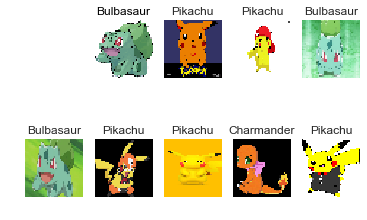

In [9]:
plt.figure()

for i in range(1,10):
    plt.subplot(2,5,i+1)
    img = X[i].reshape(40,40,3)
    label = Y[i]
    plt.title(label2pokemon[label])
    plt.imshow(img)
    plt.style.use("seaborn")
    plt.axis("off")
plt.show()

In [10]:
split = int(X.shape[0]*.8)

X_ = np.array(X)
Y_ = np.array(Y)

#Training Set
X = X_[:split,:]
Y = Y_[:split]

#Test Set
XTest = X_[split:,:]
YTest = Y_[split:]

print(X.shape,Y.shape)
print(XTest.shape,YTest.shape)

(243, 4800) (243,)
(61, 4800) (61,)


In [11]:
class NeuralNetwork:
    
    def __init__(self,input_size,layers,output_size):
        np.random.seed(0)
        
        model = {} #Dictionary
        
        #First Layer
        model['W1'] = np.random.randn(input_size,layers[0])
        model['b1'] = np.zeros((1,layers[0]))
        
        #Second Layer
        model['W2'] = np.random.randn(layers[0],layers[1])
        model['b2'] = np.zeros((1,layers[1]))
        
        #Third/Output Layer
        model['W3'] = np.random.randn(layers[1],output_size)
        model['b3'] = np.zeros((1,output_size))
        
        self.model = model
        self.activation_outputs = None
    
    def forward(self,x):
        
        W1,W2,W3 = self.model['W1'],self.model['W2'],self.model['W3']
        b1, b2, b3 = self.model['b1'],self.model['b2'],self.model['b3']
        
        z1 = np.dot(x,W1) + b1
        a1 = np.tanh(z1) 
        
        z2 = np.dot(a1,W2) + b2
        a2 = np.tanh(z2)
        
        z3 = np.dot(a2,W3) + b3
        y_ = softmax(z3)
        
        self.activation_outputs = (a1,a2,y_)
        return y_
        
    def backward(self,x,y,learning_rate=0.001):
        W1,W2,W3 = self.model['W1'],self.model['W2'],self.model['W3']
        b1, b2, b3 = self.model['b1'],self.model['b2'],self.model['b3']
        m = x.shape[0]
        
        a1,a2,y_ = self.activation_outputs
        
        delta3 = y_ - y
        dw3 = np.dot(a2.T,delta3)
        db3 = np.sum(delta3,axis=0)
        
        delta2 = (1-np.square(a2))*np.dot(delta3,W3.T)
        dw2 = np.dot(a1.T,delta2)
        db2 = np.sum(delta2,axis=0)
        
        delta1 = (1-np.square(a1))*np.dot(delta2,W2.T)
        dw1 = np.dot(X.T,delta1)
        db1 = np.sum(delta1,axis=0)
        
        
        #Update the Model Parameters using Gradient Descent
        self.model["W1"]  -= learning_rate*dw1
        self.model['b1']  -= learning_rate*db1
        
        self.model["W2"]  -= learning_rate*dw2
        self.model['b2']  -= learning_rate*db2
        
        self.model["W3"]  -= learning_rate*dw3
        self.model['b3']  -= learning_rate*db3
        
        # :)
        
    def predict(self,x):
        y_out = self.forward(x)
        return np.argmax(y_out,axis=1)
    
    def summary(self):
        W1,W2,W3 = self.model['W1'],self.model['W2'],self.model['W3']
        a1,a2,y_ = self.activation_outputs
        
        print("W1 ",W1.shape)
        print("A1 ",a1.shape)

def softmax(a):
    e_pa = np.exp(a) #Vector
    ans = e_pa/np.sum(e_pa,axis=1,keepdims=True)
    return ans

In [12]:
def loss(y_oht,p):
    l = -np.mean(y_oht*np.log(p))
    return l

def one_hot(y,depth):
    
    m = y.shape[0]
    y_oht = np.zeros((m,depth))
    y_oht[np.arange(m),y] = 1
    return y_oht

In [13]:
def train(X,Y,model,epochs,learning_rate,logs=True):
    training_loss = []
    
    classes = len(np.unique(Y))
    Y_OHT = one_hot(Y,classes)
    
    for ix in range(epochs):
        
        Y_ = model.forward(X)
        l = loss(Y_OHT,Y_)
        
        model.backward(X,Y_OHT,learning_rate)
        training_loss.append(l)
        if(logs and ix%50==0):
            print("Epoch %d Loss %.4f"%(ix,l))
            
    
    return training_loss

In [14]:
model = NeuralNetwork(input_size=4800,layers=[100,50],output_size=3)

In [15]:
X = X.reshape(X.shape[0],-1)
print(X.shape)

XTest = XTest.reshape(XTest.shape[0],-1)
print(XTest.shape)

(243, 4800)
(61, 4800)


In [16]:
l = train(X,Y,model,500,0.0002)

Epoch 0 Loss 2.9323
Epoch 50 Loss 0.1979
Epoch 100 Loss 0.0954
Epoch 150 Loss 0.0471
Epoch 200 Loss 0.0355
Epoch 250 Loss 0.0286
Epoch 300 Loss 0.0245
Epoch 350 Loss 0.0212
Epoch 400 Loss 0.0179
Epoch 450 Loss 0.0158


In [17]:
def getAccuracy(X,Y,model):
    outputs = model.predict(X)
    acc = np.sum(outputs==Y)/Y.shape[0]
    return acc
    
print("Train Acc %.4f"%getAccuracy(X,Y,model))
print("Test Acc %.4f"%getAccuracy(XTest,YTest,model))

Train Acc 0.9959
Test Acc 0.5574


In [19]:
dfTest = pd.read_csv("Dataset/Test/test.csv")

In [20]:
dfTest.head()

,ImageId
0,1106.jpg
1,2236.jpg
2,1131.jpg
3,2221.jpg
4,2011.jpg


In [21]:
saved_column = dfTest.ImageId

In [23]:
Answer_labels = []

for i in range(len(saved_column)):
    path = Path("./Dataset/Test/Images/" + saved_column[i])
    img = image.load_img(path,target_size=(40,40))
    img_array = image.img_to_array(img)
    x = np.array(img_array)
    x.shape = (1,4800)
    ans = model.predict(x)
    
    Answer_labels.append(label2pokemon[ans[0]])
#     print(label2pokemon[ans[0]])
#     drawImg(img,ans[0])

In [24]:
print(np.array(Answer_labels))

['Bulbasaur' 'Charmander' 'Bulbasaur' 'Charmander' 'Charmander'
 'Bulbasaur' 'Charmander' 'Bulbasaur' 'Bulbasaur' 'Charmander' 'Bulbasaur'
 'Bulbasaur' 'Bulbasaur' 'Bulbasaur' 'Charmander' 'Pikachu' 'Charmander'
 'Charmander' 'Pikachu' 'Charmander' 'Bulbasaur' 'Bulbasaur' 'Charmander'
 'Charmander' 'Pikachu' 'Charmander' 'Bulbasaur' 'Bulbasaur' 'Pikachu'
 'Charmander' 'Bulbasaur' 'Charmander' 'Charmander' 'Bulbasaur' 'Pikachu'
 'Bulbasaur' 'Bulbasaur' 'Bulbasaur' 'Charmander' 'Bulbasaur' 'Bulbasaur'
 'Bulbasaur' 'Charmander' 'Bulbasaur' 'Charmander' 'Bulbasaur'
 'Charmander' 'Bulbasaur' 'Charmander' 'Charmander' 'Charmander'
 'Charmander' 'Charmander' 'Bulbasaur' 'Charmander' 'Bulbasaur'
 'Charmander' 'Charmander' 'Charmander' 'Charmander' 'Charmander'
 'Charmander' 'Charmander' 'Bulbasaur' 'Pikachu' 'Bulbasaur' 'Bulbasaur'
 'Bulbasaur' 'Charmander' 'Bulbasaur' 'Bulbasaur' 'Bulbasaur' 'Bulbasaur'
 'Charmander' 'Charmander' 'Pikachu' 'Pikachu' 'Charmander' 'Bulbasaur'
 'Bulbasaur' 'Pika

In [25]:
Result = []
row_data = np.array(saved_column)
Answer_labels = np.array(Answer_labels)
for i in range(Answer_labels.shape[0]):
    res = [row_data[i],Answer_labels[i]]
    Result.append(res)


In [26]:
pd.DataFrame(Result, columns = ["ImageId","NameOfPokemon"]).to_csv('./Priyam_Garg_Submission.csv',header = True, index = False)